In [63]:
import yaml
import os
import sys
# sys.path.append('../../')
import numpy as np
from collections import Counter
from omegaconf import OmegaConf
# import torchmetrics
# import torch
# from torch import nn
from selene_sdk.utils import load_path, parse_configs_and_run
from selene_sdk.utils.config_utils import module_from_dir, module_from_file
from selene_sdk.utils.config import instantiate
from src.dataset import EncodeDataset, LargeRandomSampler, encode_worker_init_fn
from src.transforms import *
from src.utils import interval_from_line
# from torchvision import transforms
# from torchmetrics import BinnedAveragePrecision, AveragePrecision, Accuracy
from tqdm import tqdm
import pandas as pd
import copy
from src.utils import expand_dims
import gc
gc.enable()

from src.metrics import jaccard_score, threshold_wrapper
from sklearn.metrics import average_precision_score
from selene_sdk.utils.performance_metrics import compute_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of src.dataset failed: Traceback (most recent call last):
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/thurs/genv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/thurs/genv/lib/pytho

In [4]:
path = 'model_configs/biox_dnase_multi_ct_crossval.yaml'
configs = load_path(path, instantiate=False)
# configs

In [3]:
configs['dataset']['loader_args']['batch_size'] = 64

In [4]:
configs['dataset']['loader_args']

{'batch_size': 64, 'num_workers': 16}

In [5]:
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

n_folds = 5
k_fold = KFold(n_folds, shuffle=False)

In [6]:
ct_mask_range = np.array_split(range(configs['model']['class_args']['n_cell_types']), n_folds)
len(ct_mask_range)

5

In [31]:
from selene_sdk.targets import GenomicFeatures


def _construct_target(target_path, distinct_features, feature_thresholds=0.5):

    return GenomicFeatures(
        target_path,
        distinct_features,
        feature_thresholds=feature_thresholds,
    )

In [64]:
import random
from selene_sdk.utils.config_utils import get_fold_idx


def get_loaders(configs, output_dir=None, load_test=False):
    """
    """
    if "sampler" in configs:
        sampler_info = configs["sampler"]
        if output_dir is not None:
            sampler_info.bind(output_dir=output_dir)
        sampler = instantiate(sampler_info)
        return sampler
    if "dataset" in configs:
        dataset_info = configs["dataset"]

        # all intervals
        genome_intervals = []
        with open(dataset_info["sampling_intervals_path"])  as f:
            for line in f:
                chrom, start, end = interval_from_line(line)
                genome_intervals.append((chrom, start, end))

        # bedug
        # genome_intervals = random.sample(genome_intervals, k=20)
        # print("DEBUG MODE ON:", len(genome_intervals))

        with open(dataset_info["distinct_features_path"]) as f:
            distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))

        with open(dataset_info["target_features_path"]) as f:
            target_features = list(map(lambda x: x.rstrip(), f.readlines()))

        module = None
        if os.path.isdir(dataset_info["path"]):
            module = module_from_dir(dataset_info["path"])
        else:
            module = module_from_file(dataset_info["path"])

        dataset_class = getattr(module, dataset_info["class"])
        dataset_info["dataset_args"]["target_features"] = target_features
        dataset_info["dataset_args"]["distinct_features"] = distinct_features

        # load train dataset and loader
        data_config = dataset_info["dataset_args"].copy()
        data_config["intervals"] = genome_intervals

        genome_intervals_arr, tr_idx_list, val_idx_list = get_fold_idx(
            genome_intervals,  
            configs,
            )

        # train/val split
        tr_idx = tr_idx_list[dataset_info["dataset_args"]["fold"]]
        val_idx = val_idx_list[dataset_info["dataset_args"]["fold"]]
        train_intervals = genome_intervals_arr[tr_idx].tolist()
        val_intervals = genome_intervals_arr[val_idx].tolist()

        train_config = dataset_info["dataset_args"].copy()
        del train_config['fold']
        del train_config['n_folds']
        train_config["intervals"] = train_intervals
        if "train_transform" in dataset_info:
            # load transforms
            train_transform = instantiate(dataset_info["train_transform"])
            train_config["transform"] = train_transform
        train_dataset = dataset_class(**train_config)

        sampler_class = getattr(module, dataset_info["sampler_class"])
        gen = torch.Generator()
        gen.manual_seed(configs["random_seed"])
        train_sampler = sampler_class(
            train_dataset, replacement=False, generator=gen
        )

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=dataset_info["loader_args"]["batch_size"],
            num_workers=dataset_info["loader_args"]["num_workers"],
            worker_init_fn=module.encode_worker_init_fn,
            sampler=train_sampler,
        )

        # load validation dataset and loader
        val_config = dataset_info["dataset_args"].copy()
        del val_config['fold']
        del val_config['n_folds']
        val_config["intervals"] = val_intervals
        if "val_transform" in dataset_info:
            # load transforms
            val_transform = instantiate(dataset_info["val_transform"])
            val_config["transform"] = val_transform
        val_dataset = dataset_class(**val_config)

        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=dataset_info["loader_args"]["batch_size"],
            num_workers=dataset_info["loader_args"]["num_workers"],
            worker_init_fn=module.encode_worker_init_fn,
        )

        out = {
            'genome_intervals': genome_intervals_arr, 
            'train_idx': tr_idx_list,
            'val_idx': val_idx_list,
            'train_loader': train_loader, 
            'val_loader': val_loader,
        }

        return out

In [7]:
# from selene_sdk.utils.config_utils import get_loaders

out = get_loaders(configs)
genome_intervals_arr = out['genome_intervals'] 
tr_idx_list = out['train_idx']
val_idx_list = out['val_idx']
train_loader = out['train_loader']
val_loader = out['val_loader']

In [8]:
len(train_loader), len(val_loader)

(143990, 36889)

In [27]:
batch_size = val_loader.batch_size
print(batch_size)
n_cell_types = configs['model']['class_args']['n_cell_types']
# boix_target_features = val_loader.target_features
# boix_track_matrix = val_loader._feature_indices_by_cell_type_index

64


In [33]:
with open(configs['dataset']["target_features_path"]) as f:
        target_features = list(map(lambda x: x.rstrip(), f.readlines()))

with open(configs['dataset']["distinct_features_path"]) as f:
        distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))

In [11]:
# all intervals
genome_intervals = []
with open(configs['dataset']["sampling_intervals_path"])  as f:
    for line in f:
        chrom, start, end = interval_from_line(line)
        genome_intervals.append((chrom, start, end))

genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

In [8]:
genome_intervals[:4], len(genome_intervals)

([('chr1', 10500, 10680),
  ('chr1', 713420, 714955),
  ('chr1', 752395, 752905),
  ('chr1', 753270, 753580)],
 1377454)

In [68]:
def get_full_dl(configs):
    """
    """
    if "dataset" in configs:
        dataset_info = configs["dataset"]

        # all intervals
        genome_intervals = []
        with open(dataset_info["sampling_intervals_path"])  as f:
            for line in f:
                chrom, start, end = interval_from_line(line)
                genome_intervals.append((chrom, start, end))

        print(len(genome_intervals))
        # bedug
        # genome_intervals = random.sample(genome_intervals, k=20)
        # print("DEBUG MODE ON:", len(genome_intervals))

        with open(dataset_info["distinct_features_path"]) as f:
            distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))

        print(len(distinct_features))

        with open(dataset_info["target_features_path"]) as f:
            target_features = list(map(lambda x: x.rstrip(), f.readlines()))

        module = None
        if os.path.isdir(dataset_info["path"]):
            module = module_from_dir(dataset_info["path"])
        else:
            module = module_from_file(dataset_info["path"])

        dataset_class = getattr(module, dataset_info["class"])
        dataset_info["dataset_args"]["target_features"] = target_features
        dataset_info["dataset_args"]["distinct_features"] = distinct_features

        # load train dataset and loader
        data_config = dataset_info["dataset_args"].copy()
        data_config["intervals"] = genome_intervals

        # train_config = dataset_info["dataset_args"].copy()
        del data_config['fold']
        del data_config['n_folds']
        # train_config["intervals"] = genome_intervals
        if "train_transform" in dataset_info:
            # load transforms
            train_transform = instantiate(dataset_info["train_transform"])
            data_config["transform"] = train_transform
        full_dataset = dataset_class(**data_config)
        print(len(full_dataset))

        # sampler_class = getattr(module, dataset_info["sampler_class"])
        # gen = torch.Generator()
        # gen.manual_seed(configs["random_seed"])
        # train_sampler = sampler_class(
        #     full_dataset, replacement=False, generator=gen
        # )

        # full_dataloader = torch.utils.data.DataLoader(
        #     full_dataset,
        #     batch_size=dataset_info["loader_args"]["batch_size"],
        #     num_workers=dataset_info["loader_args"]["num_workers"],
        #     worker_init_fn=module.encode_worker_init_fn,
        #     sampler=train_sampler,
        # )

        return full_dataset  # full_dataloader


full_dataset = get_full_dl(configs)
# full_dataloader = get_full_dl(configs)

1377454
631
11576175


In [70]:
idx, retrieved_sample = full_dataset.__getitem__(0)

In [73]:
idx

0

In [72]:
len(retrieved_sample)

4

In [74]:
for batch in full_dataloader:
    idx, retrieved_sample = batch
    1/0

ZeroDivisionError: division by zero

In [81]:
idx.shape

torch.Size([256])

In [82]:
 _, _, targets, _ = retrieved_sample
 targets.shape

torch.Size([256, 631, 1])

In [83]:
mean_target = torch.mean(targets, dim=1).flatten() 
mean_target.shape

torch.Size([256])

In [140]:
torch.cat([idx, idx], dim=0).shape

torch.Size([512])

In [84]:
idx_np = idx.numpy()
mean_target_np = mean_target.numpy()

In [86]:
y_cat = pd.cut(mean_target_np, 10, labels=range(10))

In [105]:
# mean_target_np#.shape

In [101]:
np.array(y_cat)#.shape

array([0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 8, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 9, 0, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [108]:
from sklearn.model_selection import StratifiedKFold


train_idx = []
val_idx = []
train_y = []
val_y = []

skf = StratifiedKFold(n_splits=5, shuffle=False)
y_cat = np.array(y_cat)

for train_index, val_index in skf.split(idx_np, y_cat):
    train_idx.append(train_index)
    val_idx.append(val_index)
    train_y.append(y_cat[train_index])
    val_y.append(y_cat[val_index])
    

In [92]:
len(train_idx)

5

In [96]:
[c.shape for c in train_idx], [c.shape for c in val_idx]

([(204,), (205,), (205,), (205,), (205,)], [(52,), (51,), (51,), (51,), (51,)])

In [113]:
[Counter(i) for i in val_y]

[Counter({0: 46, 2: 2, 1: 3, 9: 1}),
 Counter({2: 2, 3: 1, 0: 46, 1: 2}),
 Counter({4: 1, 3: 1, 0: 46, 1: 2, 2: 1}),
 Counter({8: 1, 4: 1, 0: 46, 1: 2, 2: 1}),
 Counter({0: 46, 1: 3, 9: 1, 2: 1})]

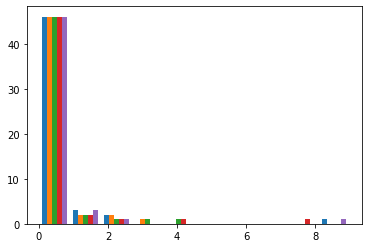

In [115]:
import matplotlib.pyplot as plt

plt.hist(val_y);

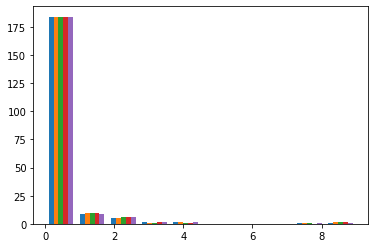

In [116]:
plt.hist(train_y);

In [141]:
d = dict()
for fold in range(len(train_idx)):
    d[fold] = (train_idx[fold], train_y[fold], val_idx[fold], val_y[fold])


In [143]:
# d[4]

In [144]:
res = pd.DataFrame.from_dict(d, orient='index', columns=['train_idx', 'train_y', 'val_idx', 'val_y'])

In [145]:
res.head()#['train_idx'][0]

,train_idx,train_y,val_idx,val_y
0,"[19, 22, 31, 40, 53, 54, 55, 56, 57, 58, 59, 6...","[2, 2, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[19, 22, 40, 53, 54, 55, 56, 57, 58, 59, 61, 6...","[2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[31, 70, 104, 105, 106, 107, 108, 109, 110, 11...","[4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[73, 114, 153, 154, 155, 156, 157, 158, 160, 1...","[8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[202, 203, 204, 206, 208, 209, 210, 211, 212, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, ..."


In [19]:
len(genome_intervals_arr)

1377454

In [53]:
len(full_dataloader)#*256

45220

In [54]:
all_mean_targets = []

for batch in tqdm(full_dataloader):
    sequence_batch, _, targets, target_mask = batch
    # print(targets.shape)
    # 1/0
    mean_target = torch.mean(targets, dim=0)
    print(mean_target.shape)
    1/0
    # y_cat = pd.cut(y, 10, labels=range(10))
    all_mean_targets.append(mean_target.numpy())
    # retrieved_seq, retrieved_target = i
    # print(retrieved_target)
    # 1/0

  0%|          | 0/45220 [00:00<?, ?it/s]

torch.Size([631, 1])


  0%|          | 0/45220 [01:03<?, ?it/s]


ZeroDivisionError: division by zero

In [55]:
targets.shape

torch.Size([256, 631, 1])

In [59]:
torch.mean(targets, dim=1).flatten().shape

torch.Size([256])

In [60]:
tmp = [torch.mean(targets, dim=1).flatten(), torch.mean(targets, dim=1).flatten()]

In [62]:
torch.cat(tmp, dim=0).shape

torch.Size([512])

In [13]:
all_mean_targets = []
all_mean_targets.append(mean_target.flatten())
all_mean_targets = torch.cat(all_mean_targets, dim=0) 

In [14]:
all_mean_targets[:10]#.shape

tensor([0.1172, 0.0273, 0.0273, 0.0352, 0.0352, 0.0273, 0.0352, 0.0312, 0.0273,
        0.0430])

In [18]:
mean_target = torch.mean(targets, dim=0)#.shape\
# mean_target.numpy()

In [45]:
full_dataset._get_chrom_pos_cell_by_idx(4)

('chr1', 713720, 0)

In [43]:
genome_intervals[1]

('chr1', 713420, 714955)

In [34]:
targets = _construct_target(
    target_path=configs['dataset']['dataset_args']['target_path'],
    distinct_features=distinct_features,
    )

In [35]:
targets

In [ ]:
bin_start = position - _start_radius
bin_end = position + _end_radius
targets_data = targets.get_feature_data(chrom, bin_start, bin_end)

In [ ]:
chrom, pos, cell_type_idx = full_dataset._get_chrom_pos_cell_by_idx(idx)

In [80]:
len(torch.utils.data.Subset(full_dataset, idx))

256

In [79]:
torch.utils.data.Subset(full_dataset, idx)

In [9]:
means = np.load('results/all_targets_mean.npy')
means.shape

(28533820,)

In [52]:
means.shape[0]/631

45220.0

In [50]:
means[-10:]

array([0.03603604, 0.05405406, 0.06306306, 0.05405406, 0.10810811,
       0.        , 0.10810811, 0.00900901, 0.01801802, 0.03603604],
      dtype=float32)

In [12]:
len(genome_intervals_arr)

1377454

In [16]:
import pandas as pd

y_cat = pd.cut(means, 10, labels=range(10))
y_cat.shape

(28533820,)

In [20]:
from collections import Counter

# Counter(y_cat)

Counter({5: 27,
         1: 795,
         2: 475,
         3: 276,
         0: 218,
         4: 73,
         8: 5,
         7: 11,
         6: 10,
         9: 3})

In [22]:
dataset_info = configs["dataset"]

# all intervals
genome_intervals = []
with open(dataset_info["sampling_intervals_path"])  as f:
    for line in f:
        chrom, start, end = interval_from_line(line)
        genome_intervals.append((chrom, start, end))

genome_intervals[:10]

[('chr1', 10500, 10680),
 ('chr1', 713420, 714955),
 ('chr1', 752395, 752905),
 ('chr1', 753270, 753580),
 ('chr1', 754045, 754605),
 ('chr1', 762595, 763055),
 ('chr1', 766170, 766430),
 ('chr1', 766595, 767180),
 ('chr1', 770945, 771205),
 ('chr1', 773070, 773355)]

In [23]:
len(genome_intervals), len(y_cat)

(1377454, 1893)

In [27]:
genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

In [32]:
from sklearn.model_selection import StratifiedKFold


train_intervals = []
val_intervals = []
train_y = []
val_y = []

skf = StratifiedKFold(n_splits=5, shuffle=False)

for train_index, val_index in skf.split(genome_intervals_arr, y_cat):
    train_intervals.append(genome_intervals_arr[train_index])
    val_intervals.append(genome_intervals_arr[val_index])
    train_y.append(y_cat[train_index])
    val_y.append(y_cat[val_index])
    # print(train_index)
    # print(genome_intervals_arr[train_index][:10])
    # 1/0


[('chr1', 1767620, 1767905) ('chr1', 1783845, 1784355)
 ('chr1', 1811995, 1813705) ('chr1', 1814445, 1815505)
 ('chr1', 1818395, 1818780) ('chr1', 1819570, 1827930)
 ('chr1', 1828320, 1831780) ('chr1', 1837095, 1843680)
 ('chr1', 1868370, 1869405) ('chr1', 1869695, 1876330)]


ZeroDivisionError: division by zero

In [ ]:
np.save('results/stratified_train_intervals.npy', train_intervals)
np.save('results/stratified_val_intervals.npy', val_intervals)


0.2

In [ ]:
def get_skf_idx(genome_intervals, configs):

    genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

    k_fold = KFold(
        configs['dataset']['dataset_args']['n_folds'], 
        shuffle=False, 
        # random_state=configs['random_seed'],
    )
    tr_idx_list = []
    val_idx_list = []

    for _, (tr_idx, val_idx) in enumerate(k_fold.split(genome_intervals_arr)):
        tr_idx_list.append(tr_idx)
        val_idx_list.append(val_idx)

    return genome_intervals_arr, tr_idx_list, val_idx_list

In [28]:
###
# fold = 1

np.random.seed(14)
n_features = 1


for fold in range(n_folds):
    print(fold)
    gts = []
    mean_preds = []
    masks = []
    for sample in tqdm(val_loader):
        batch = copy.deepcopy(sample)
        sequence_batch, _, targets, target_mask = batch
        del sample

        # make val mask
        target_mask_tr = target_mask.clone()
        target_mask_tr[:, ct_mask_range[fold][0]: ct_mask_range[fold][-1]] = False
        # val mask
        target_mask_val = ~target_mask_tr
        masked_targets = targets * target_mask_val

        1/0

        mean_seq_val = (targets).sum(axis=1) / target_mask_val.sum(axis=1)
        
        mean_batch_pred = torch.repeat_interleave(mean_seq_val, n_cell_types, dim=0)
        mean_batch_pred = mean_batch_pred.view(-1, n_features)
        batch_gt = targets.view(-1, n_features)
        #batch_mask = (target_mask_val).view(-1, n_features).astype(np.bool)
        batch_mask = (target_mask_val).view(-1, n_features)
        
        # mask of samples to save for evaluation
        save_mask = np.random.choice(mean_batch_pred.shape[0], mean_batch_pred.shape[0] // 16, replace=False)
        
        gts.append(batch_gt.data.numpy()[save_mask])
        mean_preds.append(mean_batch_pred.data.numpy()[save_mask])
        # masks for metric computation
        masks.append(batch_mask.data.numpy()[save_mask])
        del batch

    gts = expand_dims(np.concatenate(gts))
    np.save(f'results/gts_val_fold_{fold}.npy', gts)
    
    mean_preds = expand_dims(np.concatenate(mean_preds))
    np.save(f'results/mean_preds_val_fold_{fold}.npy', mean_preds)
    
    masks = expand_dims(np.concatenate(masks))
    np.save(f'results/masks_val_fold_{fold}.npy', masks)

    map_val, ap_val = compute_score(
        mean_preds, 
        gts, 
        average_precision_score, 
        target_mask=masks#.astype(np.bool)
        )

    del gts
    del mean_preds
    del masks
    gc.colect()

    print(fold, map_val, ap_val)

    np.save(f'results/mean_pos_val_ap_fold_{fold}.npy', ap_val)
    np.save(f'results/mean_pos_val_map_fold_{fold}.npy', map_val)


0


  0%|          | 0/36889 [00:02<?, ?it/s]


ZeroDivisionError: division by zero

In [16]:
gts = np.load('results/gts_val_fold_0.npy')
mean_preds = np.load('results/mean_preds_val_fold_0.npy')
masks = np.load('results/masks_val_fold_0.npy')

In [25]:
gts[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [22]:
mean_preds[:10]

array([[0.24603175],
       [0.9126984 ],
       [0.        ],
       [0.06349207],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00793651]], dtype=float32)

In [21]:
masks[:10]

array([[False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False]])

In [35]:
map_val, ap_val = compute_score(
    mean_preds, 
    gts, 
    average_precision_score, 
    target_mask=masks#.astype(np.bool)
    )

# np.save('mean_pos_val_ap_top4.npy', ap_val)
# np.save('mean_pos_val_map_top4.npy', map_val)

map_val, ap_val

(0.56052681592646, array([0.56052682]))

In [41]:
gts_1 = np.load('results/gts_val_fold_1.npy')
mean_preds_1 = np.load('results/mean_preds_val_fold_1.npy')
masks_1 = np.load('results/masks_val_fold_1.npy')

In [42]:
map_val_1, ap_val_1 = compute_score(
    mean_preds_1, 
    gts_1, 
    average_precision_score, 
    target_mask=masks_1#.astype(np.bool)
    )

map_val_1, ap_val_1

(0.545688774106069, array([0.54568877]))

In [55]:
base_scores_tr = []
base_scores_val = []

for fold, (tr_idx, val_idx) in enumerate(k_fold.split(genome_intervals_arr)):
    print(fold)

    for i, batch in enumerate(train_loader):
        sequence_batch, _, targets, target_mask = batch
        print(targets)
        print(targets.shape)
        print(target_mask.sum())
        
        # make train mask
        target_mask_tr = target_mask.clone()
        target_mask_tr[:, ct_mask_range[fold][0]: ct_mask_range[fold][-1]] = False
        print(target_mask_tr.sum())

        targets *= target_mask_tr
        print(targets)

        mean_seq_val = (targets).sum(axis=1) / target_mask_tr.sum(axis=1)
        print(mean_seq_val)
        mean_seq_batch = torch.repeat_interleave(mean_seq_val.unsqueeze(1), configs['model']['class_args']['n_cell_types'], dim=1)    
        print(mean_seq_batch.shape)
        
        # base_score = average_precision_score(mean_seq_batch, targets)
        # print('base_score', base_score)
        # base_scores_val.append(base_score)    

        1/0


0
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])
torch.Size([2, 631, 1])
tensor(1262)
tensor(1136)
tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])
tensor([[0.0018],
        [0.1884]])
torch.Size([2, 631, 1])


ZeroDivisionError: division by zero

In [63]:
base_score = average_precision_score(mean_seq_batch.numpy(), targets.numpy())
base_score

ValueError: unknown format is not supported

In [62]:
mean_seq_batch.numpy()

array([[[0.00176056],
        [0.00176056],
        [0.00176056],
        ...,
        [0.00176056],
        [0.00176056],
        [0.00176056]],

       [[0.18838029],
        [0.18838029],
        [0.18838029],
        ...,
        [0.18838029],
        [0.18838029],
        [0.18838029]]], dtype=float32)

In [58]:
targets

tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]])

In [56]:
mean_seq_batch

tensor([[[0.0018],
         [0.0018],
         [0.0018],
         ...,
         [0.0018],
         [0.0018],
         [0.0018]],

        [[0.1884],
         [0.1884],
         [0.1884],
         ...,
         [0.1884],
         [0.1884],
         [0.1884]]])

In [ ]:
base_score = average_precision_score(mean_seq_batch, targets)
print('base_score', base_score)
base_scores_val.append(base_score)    

# K-fold
## Stratified K-fold

In [8]:
genome_intervals = []
with open(cfg.datamodule.sampling_intervals_path) as f:
    for line in f:
        chrom, start, end = interval_from_line(line)
        genome_intervals.append((chrom, start, end))

print(len(genome_intervals))

genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

1377454


In [9]:
genome_intervals_arr[:10]

array([('chr1',  10500,  10680), ('chr1', 713420, 714955),
       ('chr1', 752395, 752905), ('chr1', 753270, 753580),
       ('chr1', 754045, 754605), ('chr1', 762595, 763055),
       ('chr1', 766170, 766430), ('chr1', 766595, 767180),
       ('chr1', 770945, 771205), ('chr1', 773070, 773355)],
      dtype=[('f0', '<U10'), ('f1', '<i8'), ('f2', '<i8')])

In [10]:
train_transforms = transforms.Compose([
            PermuteSequenceChannels(), 
            RandomReverseStrand(p=0.5)
        ])
        
val_transform = PermuteSequenceChannels()

In [12]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001, weight_decay = 1e-6)

In [16]:
train_loader.batch_size

2

In [93]:
tr_idx_list = []
val_idx_list = []

for fold, (tr_idx, val_idx) in enumerate(k_fold.split(genome_intervals_arr)):
    # print(fold)
    tr_idx_list.append(tr_idx)
    val_idx_list.append(val_idx)

In [92]:
val_idx_list[:3]

[array([     0,      1,      2, ..., 137743, 137744, 137745]),
 array([137746, 137747, 137748, ..., 275489, 275490, 275491]),
 array([275492, 275493, 275494, ..., 413235, 413236, 413237])]

In [98]:
len(tr_idx_list[9])

1239709

In [86]:
# ct_mask_idx = np.array_split(range(cfg.model.params.n_cell_types), 10)
# genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')
model_scores_tr = []
base_scores_tr = []
model_scores_val = []
base_scores_val = []


model = DeepCT(m_cfg)
model.train()

for fold, (tr_idx, val_idx) in enumerate(k_fold.split(genome_intervals_arr)):
    print(fold)

    # train/val split
    tr_intervals = genome_intervals_arr[tr_idx].tolist()
    val_intervals = genome_intervals_arr[val_idx].tolist()

    train_dataset = load_obj(cfg.datamodule.class_name)(
            cfg=cfg,
            distinct_features=distinct_features,
            target_features=target_features,
            intervals=tr_intervals,
            transform=train_transforms,
        )
    val_dataset = load_obj(cfg.datamodule.class_name)(
            cfg=cfg,
            distinct_features=distinct_features,
            target_features=target_features,
            intervals=val_intervals,
            transform=train_transforms,
        )
    
    train_loader = get_loader(train_dataset, batch_size=2, num_workers=1, shuffle=666)
    val_loader = get_loader(val_dataset, batch_size=2, num_workers=1, shuffle=666)

    for i, batch in enumerate(train_loader):
        sequence_batch, _, targets, target_mask = batch
        
        # make train mask
        target_mask_tr = target_mask.clone()
        target_mask_tr[:, ct_mask_idx[fold][0]: ct_mask_idx[fold][-1]] = False
        
        logits = model(sequence_batch)
        # predictions = torch.sigmoid(logits)*target_mask_tr#.view(train_loader.batch_size, cfg.model.params.n_cell_types, 1)

        criterion.weight = target_mask_tr
        loss = criterion(predictions, targets.float())
        loss = loss / criterion.weight.sum()
        print("train loss:", loss.item())

        
        # model_score = avg_pr(predictions[target_mask_tr], targets[target_mask_tr])
        # model_scores_tr.append(model_score)
        # base_score = avg_pr(mean_seq_batch[target_mask_tr], targets[target_mask_tr])

        # optimizer.zero_grad()
        # loss.backward(retain_graph=True)
        # optimizer.step()

        if i >= 2:
            break

    for batch in val_loader:
        sequence_batch, _, targets, target_mask = batch

        # val mask
        target_mask_val = ~target_mask_tr

        targets = targets * target_mask_val
        
        # compute baseline
        mean_seq_val = (targets * target_mask_val).sum(axis=1) / target_mask_val.sum(axis=1)
        print('mean_seq_val', mean_seq_val)
        mean_seq_batch = torch.repeat_interleave(mean_seq_val.unsqueeze(1), cfg.model.params.n_cell_types, dim=1)
        
        model.eval()
        with torch.no_grad():
            logits = model(sequence_batch)
            predictions = torch.sigmoid(logits)#[target_mask_val].view(val_loader.batch_size, cfg.model.params.n_cell_types, 1)
            predictions = predictions*target_mask_val

            criterion.weight = target_mask_val
            loss = criterion(predictions, targets.float())
            loss = loss / criterion.weight.sum()


            model_score_val = avg_pr(predictions, targets)
            model_scores_val.append(model_score_val)

            base_score = avg_pr(mean_seq_batch, targets)
            print('base_score', base_score)
            base_scores_val.append(base_score)

        print("val loss:", loss.item())

        if i >= 2:
            break

    break

0
train loss: 0.9745064377784729
train loss: 0.9696027636528015
train loss: 0.9762895703315735
mean_seq_val tensor([[0.0159],
        [0.0000]])
base_score tensor(0.0016)
val loss: 0.9698627591133118


In [ ]:
# проверить подсчет baseline
# подумать как сохранять модели
# впилить это всё в DeepCT

In [73]:
target_mask_val.shape

torch.Size([2, 631, 1])

In [76]:
mean_seq_batch = torch.repeat_interleave(mean_seq_val.unsqueeze(1), cfg.model.params.n_cell_types, dim=1)
mean_seq_batch.shape
# mean_seq_batch = mean_seq_batch[target_mask_val]

torch.Size([2, 631, 1])

In [79]:
mean_seq_batch = mean_seq_batch*target_mask_val
mean_seq_batch.shape

torch.Size([2, 631, 1])

In [61]:
target_mask_val.sum()

tensor(0)

{'class_name': 'pipeline.models.deepct_model_multi_ct.DeepCT', 'params': {'sequence_length': 1000, 'n_cell_types': 631, 'sequence_embedding_length': 256, 'cell_type_embedding_length': 32, 'final_embedding_length': 256, 'n_genomic_features': 1, 'conv_kernel_size': 8, 'pool_kernel_size': 4}}

In [6]:
dataset_class = getattr(module, dataset_info["class"])

load_train_val = False
load_test = False

if "dataset" in configs:
    dataset_info = configs["dataset"]
    genome_intervals = []
    # genome_intervals = np.array([])
    with open(dataset_info["sampling_intervals_path"]) as f:
        for line in f:
            chrom, start, end = line.rstrip().split("\t")[:3]
            start = int(start)
            end = int(end)
            genome_intervals.append((chrom, start, end))
            # genome_intervals = np.append(genome_intervals, (chrom, start, end))
            
    with open(dataset_info["distinct_features_path"]) as f:
        distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))

    with open(dataset_info["target_features_path"]) as f:
        target_features = list(map(lambda x: x.rstrip(), f.readlines()))

dataset_info["dataset_args"]["target_features"] = target_features
dataset_info["dataset_args"]["distinct_features"] = distinct_features


In [7]:
genome_intervals[:5], len(genome_intervals)

([('chr1', 10500, 10680),
  ('chr1', 713420, 714955),
  ('chr1', 752395, 752905),
  ('chr1', 753270, 753580),
  ('chr1', 754045, 754605)],
 1377454)

In [8]:
distinct_features[:5], len(distinct_features)

(['8988T|DNase-seq|None',
  'A172|DNase-seq|None',
  'A549_treated_with_100_nM_dexamethasone_for_10_hours|DNase-seq|None',
  'A549_treated_with_100_nM_dexamethasone_for_12_hours|DNase-seq|None',
  'A549_treated_with_100_nM_dexamethasone_for_1_hour|DNase-seq|None'],
 631)

In [9]:
# distinct_features == tracks (feature + cell_type)
data_config = dataset_info["dataset_args"].copy()
data_config["intervals"] = genome_intervals

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

fold = KFold(10, shuffle=False)
# fold = KFold(10, shuffle=True, random_state=666)

In [11]:
data_config = dataset_info["dataset_args"].copy()
data_config["intervals"] = genome_intervals

full_dataset = dataset_class(**data_config)

In [17]:
# train_dataset.__getitem__(0)

In [12]:
# genome_intervals#_arr

In [13]:
# np.asarray(genome_intervals, dtype='U10,i8,i8')

In [15]:
# 1 - loc folds

batch_size = dataset_info['loader_args']['batch_size']
train_transform = instantiate(dataset_info["train_transform"])
val_transform = PermuteSequenceChannels()

sampler_class = getattr(module, dataset_info["sampler_class"])
gen = torch.Generator()
gen.manual_seed(configs["random_seed"])


genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

for f, (tr_idx, val_idx) in enumerate(fold.split(genome_intervals_arr)):
    tr_intervals = genome_intervals_arr[tr_idx].tolist()
    val_intervals = genome_intervals_arr[val_idx].tolist()

    train_config = dataset_info["dataset_args"].copy()
    train_config["intervals"] = tr_intervals
    train_config["transform"] = train_transform

    val_config = dataset_info["dataset_args"].copy()
    val_config["intervals"] = val_intervals
    val_config["transform"] = val_transform

    train_dataset = dataset_class(**train_config)
    val_dataset = dataset_class(**val_config)

    train_sampler = sampler_class(
        train_dataset, replacement=False, generator=gen)

    val_sampler = sampler_class(
        val_dataset, replacement=False, generator=gen)


    # train_dataset = GenSubset(full_dataset, tr_idx, transform=train_transform)
    # val_dataset = GenSubset(full_dataset, val_idx, transform=val_transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size,
                                            num_workers=dataset_info["loader_args"]["num_workers"],
                                            worker_init_fn=module.encode_worker_init_fn,
                                            sampler=train_sampler,
                                        )
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                            batch_size=batch_size,
                                            num_workers=dataset_info["loader_args"]["num_workers"],
                                            worker_init_fn=module.encode_worker_init_fn,
                                            sampler=val_sampler,
                                        )

    print(len(train_loader), len(val_loader))



    1/0

1032815 124804


ZeroDivisionError: division by zero

In [35]:
for f, (tr_idx, val_idx) in enumerate(fold.split(genome_intervals_arr)):
    tr_intervals = genome_intervals_arr[tr_idx].tolist()
    val_intervals = genome_intervals_arr[val_idx].tolist()

    print(f, val_idx)
    # 1/0

0 [     0      1      2 ... 137743 137744 137745]
1 [137746 137747 137748 ... 275489 275490 275491]
2 [275492 275493 275494 ... 413235 413236 413237]
3 [413238 413239 413240 ... 550981 550982 550983]
4 [550984 550985 550986 ... 688726 688727 688728]
5 [688729 688730 688731 ... 826471 826472 826473]
6 [826474 826475 826476 ... 964216 964217 964218]
7 [ 964219  964220  964221 ... 1101961 1101962 1101963]
8 [1101964 1101965 1101966 ... 1239706 1239707 1239708]
9 [1239709 1239710 1239711 ... 1377451 1377452 1377453]


In [13]:
from pipeline.models.deepct_model_multi_ct import DeepCT

model = DeepCT(**configs['model']['class_args'])
model.train()

DeepCT(
  (conv_net): Sequential(
    (0): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(320, 320, kernel_size=(8,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
    (7): ReLU(inplace=True)
    (8): Conv1d(480, 480, kernel_size=(8,), stride=(1,))
    (9): ReLU(inplace=True)
    (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm1d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
    (14): ReLU(inplace=True)
    (15): Conv1d(960, 960, kernel_size=(8,), stride=(1,))
    (16): ReLU(inplace=True)
    (17): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True,

In [75]:
# retrieved_seq, cell_type, target, target_mask
sequence_batch = batch[0]#.to(device)
cell_type_batch = batch[1]#.to(device)
targets = batch[2]#.to(device)
target_mask = batch[3]#.to(device)

In [40]:
targets.shape, target_mask.shape, cell_type_batch.shape

(torch.Size([10, 631, 1]), torch.Size([10, 631, 1]), torch.Size([10]))

In [66]:
target_mask.shape[1]

631

In [10]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001, weight_decay = 1e-6)

In [12]:
criterion.reduction

'sum'

In [23]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 1e-06
)

In [73]:
model = DeepCT(**configs['model']['class_args'])
model.train()


batch_size = dataset_info['loader_args']['batch_size']
train_transform = instantiate(dataset_info["train_transform"])
val_transform = PermuteSequenceChannels()

sampler_class = getattr(module, dataset_info["sampler_class"])
gen = torch.Generator()
gen.manual_seed(configs["random_seed"])

ct_mask_idx = np.array_split(range(configs['model']['class_args']['n_cell_types']), 10)

genome_intervals_arr = np.asarray(genome_intervals, dtype='U10,i8,i8')

for f, (tr_idx, val_idx) in enumerate(fold.split(genome_intervals_arr)):
    tr_intervals = genome_intervals_arr[tr_idx].tolist()
    val_intervals = genome_intervals_arr[val_idx].tolist()

    train_config = dataset_info["dataset_args"].copy()
    train_config["intervals"] = tr_intervals
    train_config["transform"] = train_transform

    val_config = dataset_info["dataset_args"].copy()
    val_config["intervals"] = val_intervals
    val_config["transform"] = val_transform

    train_dataset = dataset_class(**train_config)
    val_dataset = dataset_class(**val_config)

    train_sampler = sampler_class(
        train_dataset, replacement=False, generator=gen)

    val_sampler = sampler_class(
        val_dataset, replacement=False, generator=gen)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size,
                                            num_workers=dataset_info["loader_args"]["num_workers"],
                                            worker_init_fn=module.encode_worker_init_fn,
                                            sampler=train_sampler,
                                        )
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                            batch_size=batch_size,
                                            num_workers=dataset_info["loader_args"]["num_workers"],
                                            worker_init_fn=module.encode_worker_init_fn,
                                            sampler=val_sampler,
                                        )

    for batch in train_loader:
        sequence_batch = batch[0]#.to(device)
        cell_type_batch = batch[1]#.to(device)
        targets = batch[2]#.to(device)
        target_mask = batch[3]#.to(device)
        
        target_mask_tr = target_mask.clone()
        target_mask_tr[:, ct_mask_idx[f][0]: ct_mask_idx[f][-1]] = False
        
        outputs = model(sequence_batch, cell_type_batch)

        criterion.weight = target_mask_tr
        loss = criterion(outputs, targets)
        loss = loss / criterion.weight.sum()
        print("train loss:", loss.item())

        predictions = torch.sigmoid(outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        break

    break

    # for batch in val_loader:
    #     sequence_batch = batch[0]#.to(device)
    #     cell_type_batch = batch[1]#.to(device)
    #     targets = batch[2]#.to(device)
    #     target_mask = batch[3]#.to(device)

    #     # val mask
    #     target_mask_val = ~target_mask

    #     model.eval()
    #     with torch.no_grad():
    #         outputs = model(sequence_batch, cell_type_batch)

    #         criterion.weight = target_mask_val
    #         loss = criterion(outputs, targets)
    #         loss = loss / criterion.weight.sum()

    #         val_predictions = torch.sigmoid(outputs)


    #     print("val loss:", loss.item())


        # break

    # 1/0

    

train loss: 0.00011682936747092754


In [67]:
# ct_mask_idx = np.array_split(range(configs['model']['class_args']['n_cell_types']), 10)
# [len(c) for c in ct_mask_idx]

[64, 63, 63, 63, 63, 63, 63, 63, 63, 63]

In [74]:
criterion.weight[1]

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

In [76]:
criterion.weight[1].sum()

tensor(568)

In [77]:
for batch in val_loader:
    sequence_batch = batch[0]#.to(device)
    cell_type_batch = batch[1]#.to(device)
    targets = batch[2]#.to(device)
    # target_mask = batch[3]#.to(device)

    # val mask
    target_mask_val = ~target_mask_tr

    model.eval()
    with torch.no_grad():
        outputs = model(sequence_batch, cell_type_batch)

        criterion.weight = target_mask_val
        loss = criterion(outputs, targets)
        loss = loss / criterion.weight.sum()

        val_predictions = torch.sigmoid(outputs)


    print("val loss:", loss.item())
    break

val loss: 0.0001089841389330104


In [78]:
criterion.weight[1]

tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True

In [80]:
criterion.weight[1].sum()

tensor(63)

In [141]:
sequence_batch.shape, cell_type_batch.shape, targets.shape

(torch.Size([10, 4, 1000]), torch.Size([10]), torch.Size([10, 631, 1]))

In [144]:
outputs = model(sequence_batch, cell_type_batch)
outputs.shape

torch.Size([10, 631, 1])

In [145]:
criterion.weight = target_mask_tr
loss = criterion(outputs, targets)
loss = loss / criterion.weight.sum()
loss.item()

tensor(0.0001, grad_fn=<DivBackward0>)

In [147]:
predictions = torch.sigmoid(outputs)
predictions.shape

torch.Size([10, 631, 1])

In [149]:
model.eval()

for val_batch in val_loader:
    val_sequence_batch = val_batch[0]#.to(device)
    val_cell_type_batch = val_batch[1]#.to(device)
    val_targets = val_batch[2]#.to(device)
    val_target_mask = val_batch[3]#.to(device)

    with torch.no_grad():
        outputs = model(val_sequence_batch, val_cell_type_batch)

        criterion.weight = target_mask_val
        loss = criterion(outputs, val_targets)
        loss = loss / criterion.weight.sum()

        val_predictions = torch.sigmoid(outputs)

        break


In [150]:
loss.item()

0.00010881867638090625

In [155]:
val_predictions#.shape

tensor([[[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]],

        [[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]],

        [[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]],

        ...,

        [[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]],

        [[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]],

        [[0.4966],
         [0.4966],
         [0.4966],
         ...,
         [0.4966],
         [0.4966],
         [0.4966]]])